### Dataset



Downloding pre-trained models and further train them through feature extraction and finetuning on our Marvel dataset.

Comparing the models with a third model trained from scratch.

In [4]:
# make any other necessary imports here
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Define hyperparameters

In [5]:
# define hyperparameters
data_dir = "/content/gdrive/MyDrive/marvel"


# Number of classes in the dataset
num_classes = 9

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params i.e  perform feature extraction
feature_extract = True

### Data Load

Load the data and initialize dataloaders here.


In [6]:
#Code here
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


### Helper Functions

Define the train_model function here.

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(25):
        print('Epoch {}/{}'.format(epoch, 25 - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [8]:
#Code here
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Define the initialize_model function here, you do not need to include all the categories , simply include the one or more relevant to the model you are using.

In [9]:
#Code here

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224



    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("vgg", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Creating Optimizer

We have to send the model to our device, which could be the GPU or CPU.


In [10]:
# Send the model to GPU
#Code here
# Send the model to GPU
model_ft = model_ft.to(device)



In [11]:

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
feature extraction
	 classifier.6.weight
	 classifier.6.bias


In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001,momentum= 0.9)
criterion = nn.CrossEntropyLoss()

#Code here


### Training the model


Now we use the function defined above tp train the model.

---



In [13]:
# Observe that all parameters are being optimized

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/24
----------
train Loss: 1.7601 Acc: 0.3913
val Loss: 1.3427 Acc: 0.5580

Epoch 1/24
----------
train Loss: 1.5717 Acc: 0.4782
val Loss: 1.3754 Acc: 0.5658

Epoch 2/24
----------
train Loss: 1.5281 Acc: 0.4958
val Loss: 1.2580 Acc: 0.5953

Epoch 3/24
----------
train Loss: 1.5279 Acc: 0.4919
val Loss: 1.2490 Acc: 0.5855

Epoch 4/24
----------
train Loss: 1.5347 Acc: 0.4940
val Loss: 1.2415 Acc: 0.6012

Epoch 5/24
----------
train Loss: 1.5272 Acc: 0.4979
val Loss: 1.2622 Acc: 0.5874

Epoch 6/24
----------
train Loss: 1.5022 Acc: 0.5060
val Loss: 1.2654 Acc: 0.5972

Epoch 7/24
----------
train Loss: 1.5092 Acc: 0.5113
val Loss: 1.2215 Acc: 0.5933

Epoch 8/24
----------
train Loss: 1.5169 Acc: 0.5067
val Loss: 1.2300 Acc: 0.6071

Epoch 9/24
----------
train Loss: 1.5017 Acc: 0.5155
val Loss: 1.2257 Acc: 0.6071

Epoch 10/24
----------
train Loss: 1.4887 Acc: 0.5130
val Loss: 1.2480 Acc: 0.5953

Epoch 11/24
----------
train Loss: 1.5370 Acc: 0.4968
val Loss: 1.2611 Acc: 0.5953

Ep

### Finetuning

We will now perform finetuning, let's initialize a new model

In [14]:
#Code here
model_ft2, input_size = initialize_model("vgg", num_classes, feature_extract, use_pretrained=True)
optimizer_ft = optim.SGD(params_to_update, lr=0.001,momentum= 0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)
#Code here

In [16]:
feature_extract=False

In [17]:



params_to_update = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
finetuning 
	 classifier.6.weight
	 classifier.6.bias


now repeat the above process to train the model.

In [18]:
#Code here
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/24
----------
train Loss: 1.4822 Acc: 0.5232
val Loss: 1.2055 Acc: 0.6169

Epoch 1/24
----------
train Loss: 1.5301 Acc: 0.5102
val Loss: 1.1535 Acc: 0.6365

Epoch 2/24
----------
train Loss: 1.5080 Acc: 0.5190
val Loss: 1.1702 Acc: 0.6267

Epoch 3/24
----------
train Loss: 1.5239 Acc: 0.5091
val Loss: 1.2352 Acc: 0.6090

Epoch 4/24
----------
train Loss: 1.4718 Acc: 0.5260
val Loss: 1.1838 Acc: 0.6248

Epoch 5/24
----------
train Loss: 1.4747 Acc: 0.5211
val Loss: 1.1937 Acc: 0.6228

Epoch 6/24
----------
train Loss: 1.5113 Acc: 0.5218
val Loss: 1.2241 Acc: 0.6012

Epoch 7/24
----------
train Loss: 1.4828 Acc: 0.5201
val Loss: 1.1917 Acc: 0.6169

Epoch 8/24
----------
train Loss: 1.5075 Acc: 0.5141
val Loss: 1.2014 Acc: 0.6071

Epoch 9/24
----------
train Loss: 1.4779 Acc: 0.5144
val Loss: 1.1795 Acc: 0.6444

Epoch 10/24
----------
train Loss: 1.4753 Acc: 0.5355
val Loss: 1.1875 Acc: 0.6464

Epoch 11/24
----------
train Loss: 1.4881 Acc: 0.5267
val Loss: 1.2369 Acc: 0.6228

Ep

### Training from scratch

Train a third model from scratch, similar as above.


We won't have to worry about updating layers, simply set `use_pretrained=False` in initialize_model function, send model to device, define optimizer and loss and run training.

In [19]:
#Code here
scratch_model,_ = initialize_model("vgg", num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=False)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]




Epoch 0/24
----------
train Loss: 2.4883 Acc: 0.1207
val Loss: 2.1798 Acc: 0.1572

Epoch 1/24
----------
train Loss: 2.2024 Acc: 0.1735
val Loss: 2.1105 Acc: 0.1866

Epoch 2/24
----------
train Loss: 2.1367 Acc: 0.1823
val Loss: 2.0513 Acc: 0.2534

Epoch 3/24
----------
train Loss: 2.1206 Acc: 0.2020
val Loss: 1.9938 Acc: 0.2888

Epoch 4/24
----------
train Loss: 2.0958 Acc: 0.2139
val Loss: 2.0431 Acc: 0.2161

Epoch 5/24
----------
train Loss: 2.0942 Acc: 0.2104
val Loss: 2.0406 Acc: 0.2652

Epoch 6/24
----------
train Loss: 2.0772 Acc: 0.2231
val Loss: 1.9594 Acc: 0.2986

Epoch 7/24
----------
train Loss: 2.0713 Acc: 0.2090
val Loss: 1.9509 Acc: 0.3104

Epoch 8/24
----------
train Loss: 2.0489 Acc: 0.2361
val Loss: 1.9597 Acc: 0.2809

Epoch 9/24
----------
train Loss: 2.0493 Acc: 0.2266
val Loss: 1.9623 Acc: 0.2927

Epoch 10/24
----------
train Loss: 2.0414 Acc: 0.2533
val Loss: 1.9336 Acc: 0.3281

Epoch 11/24
----------
train Loss: 2.0314 Acc: 0.2523
val Loss: 1.9641 Acc: 0.3202

Ep

### Comparing models

using data from all three models you have trained, plot a graph comparing validation Accuracy vs. Number of Epochs for your models for performance comparison.

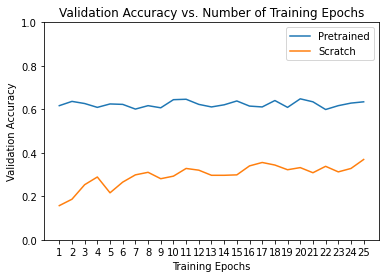

In [20]:
#Code here
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()